In [1]:
%pylab inline
import numpy as np
np.set_printoptions(precision=4, linewidth=150)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import scipy.interpolate as interpolate
import scipy.integrate as integrate
import scipy.optimize as optimize

import lal
import lalsimulation

import pycbc.filter
import pycbc.types
import pycbc.psd

Populating the interactive namespace from numpy and matplotlib



In [2]:
sys.path.insert(0, '../src')

import waveform as wave
import waveformset as ws
import trainingset as train
import taylorf2
import gaussianprocessregression as gpr
import designofexperiment as doe
#import pycbcwaveform as pycbcwave
import lalwaveform
import plotparams
import greedy
import empiricalinterpolation as eim
import surrogate
import diagnostics
import fisher

import imp
imp.reload(wave)
imp.reload(ws)
imp.reload(train)
imp.reload(taylorf2)
imp.reload(gpr)
imp.reload(doe)
#imp.reload(pycbcwave)
imp.reload(lalwaveform)
imp.reload(greedy)
imp.reload(eim)
imp.reload(surrogate)
imp.reload(diagnostics)
imp.reload(fisher)

import constants
imp.reload(constants)
from constants import *

# Load GPSurrogate and WaveformSets

In [3]:
# Bamp_filename = '../data/Bamp.hdf5'
# Bphase_filename = '../data/Bphase.hdf5'
# damp_gp_filename = '../data/amp_gp.hdf5'
# dphase_gp_filename = '../data/phase_gp.hdf5'
# sur = surrogate.GPSurrogate.load(Bamp_filename, Bphase_filename, damp_gp_filename, dphase_gp_filename)

# Bamp_filename = '../data/Bamp_p00015.hdf5'
# Bphase_filename = '../data/Bphase_p00015.hdf5'
# damp_gp_filename = '../data/amp_gp_p00015.hdf5'
# dphase_gp_filename = '../data/phase_gp_p00015.hdf5'
# sur = surrogate.GPSurrogate.load(Bamp_filename, Bphase_filename, damp_gp_filename, dphase_gp_filename)

Bamp_filename = '../data/Bamp_p00015_n1056.hdf5'
Bphase_filename = '../data/Bphase_p00015_n1056.hdf5'
damp_gp_filename = '../data/amp_gp_p00015_n1056.hdf5'
dphase_gp_filename = '../data/phase_gp_p00015_n1056.hdf5'
sur = surrogate.GPSurrogate.load(Bamp_filename, Bphase_filename, damp_gp_filename, dphase_gp_filename)

In [4]:
# testset_rand = ws.HDF5WaveformSet('../data/h_test_set_rand.hdf5')
testset_rand = ws.HDF5WaveformSet('../data/h_test_set_rand_p00015_n1000.hdf5')

# Systematic error calculation

In [5]:
def surrogate_fisher_params(params, f_min, f_max, npoints=1000):
    """Wrapper for TaylorF2 with Fisher-matrix parameters.
    phase_order=4 corresponds to 2PN order.
    """
    lndist, f0tc, phic, lnmc, lneta, ssym, santi, tlambda, dtlambda = params
    
    distance = np.exp(lndist)
    mc = np.exp(lnmc)
    eta = np.exp(lneta)
    
    mass1 = fisher.m1_of_mchirp_eta(mc, eta)
    mass2 = fisher.m2_of_mchirp_eta(mc, eta)
    spin1z, spin2z = fisher.s1_s2_of_pe_params(ssym, santi)
    lambda1, lambda2 = fisher.lam1_lam2_of_pe_params(eta, tlambda, dtlambda)
    
    #print distance, f0tc, phic, mass1, mass2, spin1z, spin2z, lambda1, lambda2
    
    h = sur.physical_waveform_zero_inclination(
    mass1=mass1, mass2=mass2, 
    spin1z=spin1z, spin2z=spin2z, 
    lambda1=lambda1, lambda2=lambda2,
    distance=distance)
    
    # Resample waveform
    fs = np.logspace(np.log10(f_min), np.log10(f_max), npoints)
    h.resample(fs)
    
    # Set the phase at the last data point to phic
    h.phase += phic - h.phase[-1]
    
    # Shift the coalescence time by f0tc (add 2 \pi f f0tc to Fourier transformed phase)
    h.phase += 2.*np.pi*h.x*f0tc
    
    return h

In [6]:
def evaluate_statistical_systematic_errors(i, mass2, surrogate_fisher_params, testset, snr, psd_array, f_min):
    
    q, spin1z, spin2z, lambda1, lambda2 = testset.get_waveform(i, data='parameters')
    mass1 = mass2/q
    mtot = mass1 + mass2
    
    # Initial distance guess before knowing the snr
    distance0 = 100.
    
    #f_min = 1.05*mf_to_f(sur.mf_a, mtot)
    f_max = 0.95*mf_to_f(sur.mf_b, mtot)
    
    mchirp = fisher.mchirp_of_m1_m2(mass1, mass2)
    eta = fisher.eta_of_m1_m2(mass1, mass2)
    
    # Fisher matrix parameters
    lndist0 = np.log(distance0)
    f0tc = 0.0
    phic = 0.0
    lnmc = np.log(mchirp)
    lneta = np.log(eta)
    ssym = fisher.ssym_of_s1_s2(spin1z, spin2z)
    santi = fisher.santisym_of_s1_s2(spin1z, spin2z)
    tlambda = fisher.lamtilde_of_eta_lam1_lam2(eta, lambda1, lambda2)
    dtlambda = fisher.deltalamtilde_of_eta_lam1_lam2(eta, lambda1, lambda2)
    params0 = [lndist0, f0tc, phic, lnmc, lneta, ssym, santi, tlambda, dtlambda]
    
    # Initialize Fisher matrix
    fisher_sur0 = fisher.NumericalFisher(surrogate_fisher_params, params0, f_min, f_max, psd_array)
    
    # Determine correct distance for given SNR
    snr0 = fisher_sur0.snr()
    distance = distance0 * (snr0/snr)
    params = list(params0)
    params[0] = np.log(distance)
    #print params0
    #print params
    # Now initialize Fisher matrix with correct distance
    fisher_sur = fisher.NumericalFisher(surrogate_fisher_params, params, f_min, f_max, psd_array)
    #print fisher_sur.snr()
    
    # Get exact waveform
    h_exact_geom = testset[i]
    h_exact = wave.dimensionless_to_physical_freq(h_exact_geom, mtot, distance)
    
    param_indices = [1, 2, 3, 4, 7]
    dthetas = [0, 0.001, 0.1, 0.001, 0.0001, 0, 0, 10.0, 0]
    dtypes = ['central', 'central', 'central', 'backward', 'central']

    if lambda1 < 100. or lambda2 < 100.: 
        dtypes[4] = 'forward'
    if lambda1 > 9900. or lambda2 > 9900.: 
        dtypes[4] = 'backward'
        
    prior_sigmas = [None, None, None, None, None]
    
    fisher_sur.derivative_list_eval(param_indices, dthetas, dtypes)
    fisher_sur.fisher_matrix();
    fisher_sur.prior_matrix(prior_sigmas)
    cov = fisher_sur.covariance_matrix()
    stat_err = fisher_sur.get_sigmas()
    sys_err = fisher_sur.systematic_error(h_exact)
    
    #print 'Statistical error:'
    #print stat_err
    #print 'Systematic error:'
    #print sys_err
    #print 'Sys/Stat error'
    #print sys_err/stat_err
    
    return stat_err, sys_err

In [12]:
mass2 = 1.01
testset = testset_rand
snr = 30.
f_min = 20.

# The file is actually an ASD not a PSD
psd_array = np.loadtxt('/Users/lackey/Research/NoiseCurves/LIGO/ZERO_DET_high_P.txt') 
psd_array[:, 1] = psd_array[:, 1]**2

stat_err_list = []
sys_err_list = []
for i in range(0, len(testset), 1):
    print i,
    stat, sys = evaluate_statistical_systematic_errors(
        i, mass2, surrogate_fisher_params, testset, snr, psd_array, f_min)
    stat_err_list.append(stat)
    sys_err_list.append(sys)
    
stat_err_list = np.array(stat_err_list)
sys_err_list = np.array(sys_err_list)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202

ValueError: Mass of less massive star must be >= 1M_sun.

In [9]:
np.sort(stat_err_list[:, 4]), np.sort(np.abs(sys_err_list[:, 4]))

(array([ 312.1942,  353.1466,  410.2661,  426.001 ,  538.132 ,  733.5276,  764.9729,  781.2828,  788.467 ,  813.7705,  825.3089,  831.7903,  851.581 ,
         858.2439,  860.3064,  897.2165,  938.748 ,  947.5671,  950.5386,  995.6823]),
 array([  12.2491,   34.9878,   42.8948,   72.9893,   80.2482,   87.6527,  200.0373,  235.4138,  265.0255,  295.9926,  298.7083,  355.4949,  467.4724,
         481.0348,  488.9621,  514.4684,  527.8913,  531.9226,  639.0457,  808.6753]))

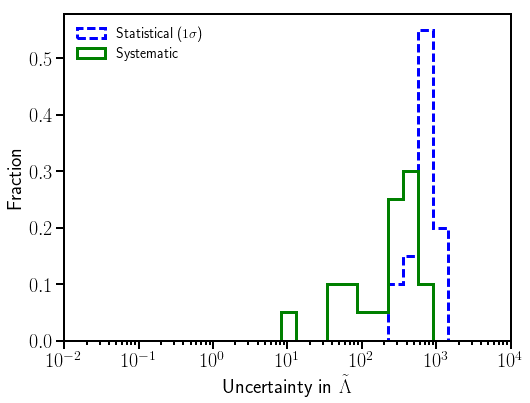

In [10]:
fig, axes = plt.subplots(1, figsize=(8, 6))

Nsamp = len(stat_err_list)
error = stat_err_list[:, 4]
axes.hist(error, bins=np.logspace(-5, 5, 50), weights=np.ones(Nsamp)/Nsamp, histtype='step', 
          ls='--', lw=3, color='blue', alpha=1.0, label=r'Statistical ($1\sigma$)')

Nsamp = len(sys_err_list)
error = np.abs(sys_err_list[:, 4])
axes.hist(error, bins=np.logspace(-5, 5, 50), weights=np.ones(Nsamp)/Nsamp, histtype='step', 
          ls='-', lw=3, color='green', alpha=1.0, label=r'Systematic')

axes.set_xscale("log")
#axes.set_yscale("log")
axes.set_xlim([0.01, 10000.])
#axes.set_ylim([1, 1.0e8])
axes.set_xlabel(r'Uncertainty in $\tilde\Lambda$')
axes.set_ylabel(r'Fraction')
axes.legend(loc='upper left', frameon=False)

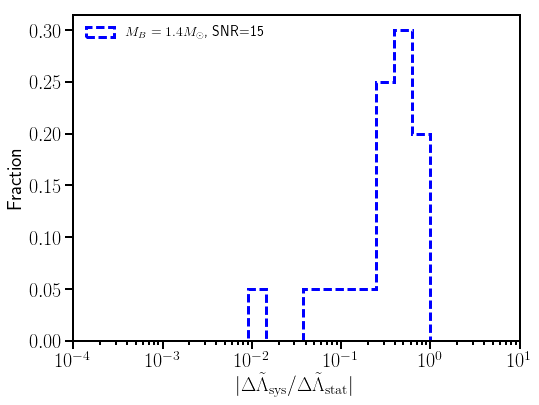

In [11]:
fig, axes = plt.subplots(1, figsize=(8, 6))

Nsamp = len(stat_err_list)
error = np.abs(sys_err_list[:, 4]) / stat_err_list[:, 4]
axes.hist(error, bins=np.logspace(-10, 0, 50), weights=np.ones(Nsamp)/Nsamp, histtype='step', 
          ls='--', lw=3, color='blue', alpha=1.0, label=r'$M_B=1.4M_\odot$, SNR=15')

axes.set_xscale("log")
#axes.set_yscale("log")
axes.set_xlim([1.0e-4, 1.0e1])
#axes.set_ylim([1, 1.0e8])
axes.set_xlabel(r'$|\Delta\tilde\Lambda_{\rm sys} / \Delta\tilde\Lambda_{\rm stat}|$')
axes.set_ylabel(r'Fraction')
axes.legend(loc='upper left', frameon=False)
#fig.savefig('/home/bdlackey/public_html/ROM/mismatchhist.pdf', format='pdf', transparent=True, bbox_inches='tight')

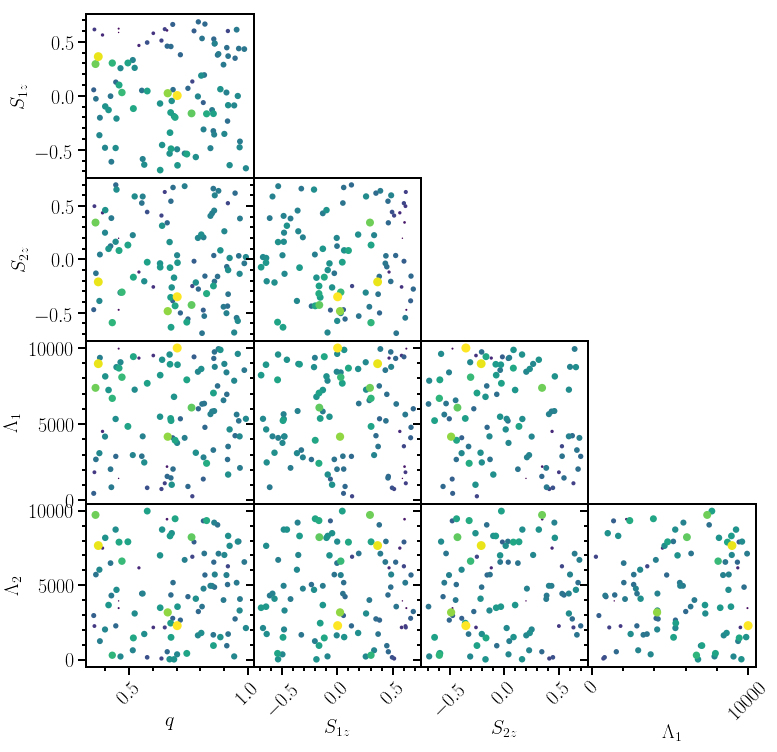

In [41]:
labels = [r'$q$', r'$S_{1z}$', r'$S_{2z}$', r'$\Lambda_1$', r'$\Lambda_2$']
params = testset_rand.parameters()
error = stat_err_list[:, 4]
fig, ax = diagnostics.error_2d_triangle_plot(params, error, labels, threshold=None, figsize=(10, 10))

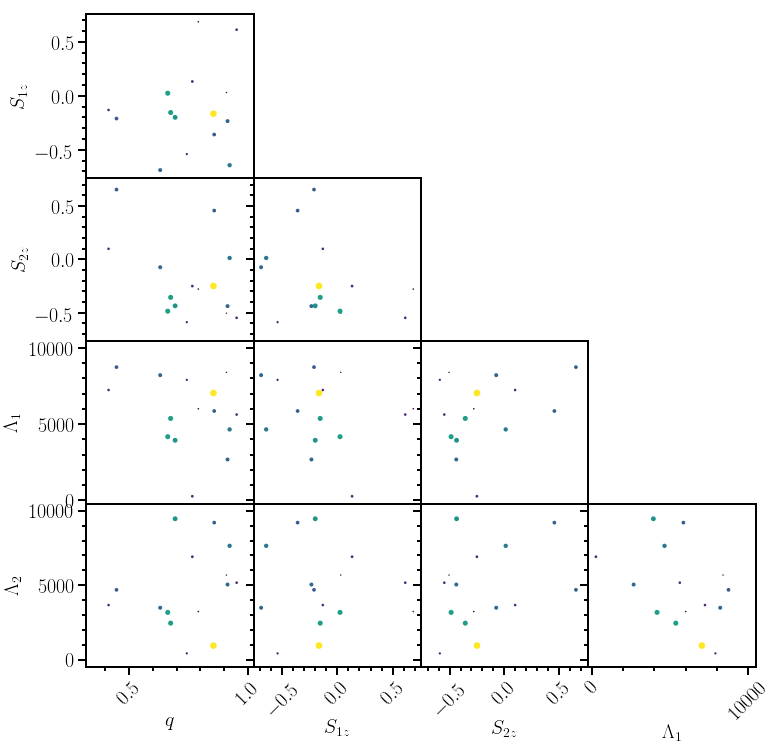

In [45]:
labels = [r'$q$', r'$S_{1z}$', r'$S_{2z}$', r'$\Lambda_1$', r'$\Lambda_2$']
params = testset_rand.parameters()
error = np.abs(sys_err_list[:, 4])
fig, ax = diagnostics.error_2d_triangle_plot(params, error, labels, threshold=500, figsize=(10, 10))

In [43]:
error = np.abs(sys_err_list[:, 4])
htest_indices = np.where(error>500)[0]

In [46]:
htest_indices

array([ 2,  3,  9, 15, 38, 43, 53, 56, 63, 68, 74, 75, 85, 95, 99])